### Урок 5. #Задача оттока: варианты постановки, возможные способы решения##

Удержание состоит из следующих этапов:
1. определить сегмент, кого удерживать (это как раз наша часть)
2. определить, что предлагать
3. сделать предложение
4. дождаться реакции
5. оценить результаты

При этом прогноз должен быть сделан немного раньше, чем когда пользователь уже уйдет)

### Метрики удержания

- return rate (конверсия возврата)
- churn rate (конверсия оттока)
- N-day retention (удержание на день N)

return rate = (текущее количество активных пользователей из набора данных)/(общее количество пользователей из набора данных)*100

churn rate = (количество пользователей из набора данных, ушедших в отток)/(общее количество пользователей из набора данных)*100

"Базируясь на предположении, что модель машинного обучения сможет сегментировать пользователей на тех, кто уходит в отток и нет, <b>не превышая ошибку в X%</b>, мы предполагаем, что реализовав такую систему прогнозирования вероятности оттока, основанную на ML, мы сможем выделить сегмент пользователей, которые собираются уйти в отток и провести кампанию по удержанию, что приведет к тому, что большинство таких пользователей останутся с нами в будущем. Мы увидим это по <b>увеличению доли пользователей, оставшихся с нами на день N</b> ,и можем измерить ее с помощью метрики <b>удержание N-го дня</b>. Мы полагаем, что изменение приведет к хорошим результатам для компании, т.к увеличит удержание пользователей и, как следствие, увеличение выручки для компании"

### Практика

### Case 1

Давайте поработаем с набором данных с платформы kaggle https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers по оттоку клиентов банка

In [260]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [261]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить. 

Посмотрим на распределение классов:

In [262]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Не самое плохое распределение (1 к 4)

Давайте построим модель. Сразу же будем работать с использованием sklearn pipeline

In [263]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные стандартизируем

In [264]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [265]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Зададим списки признаков

In [266]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Посмотрим как это работает на примере отдельного категориального признака - Gender

In [267]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
9394,1,0
898,1,0
2398,1,0


Ананлогичный пример для вещественного признака (стандартизируем признак Age)

In [268]:
Age =  Pipeline([
                ('selector', NumberSelector(key = 'Age')),
                ('standard', StandardScaler())
            ])
Age.fit(X_train)
Age.transform(X_test)#.head(3)

array([[-0.36637708],
       [ 0.11067641],
       [ 0.3014978 ],
       ...,
       [ 0.01526571],
       [-0.08014499],
       [-0.74801987]])

Теперь нам нужно под каждый признак создать трансформер и объединить их в список (сделаем это в цикле, чтобы не мучиться)

In [269]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [270]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

Добавим модель

In [271]:
from sklearn.ensemble import RandomForestClassifier

pipeline_RFC = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(max_depth= None, max_features=0.5, min_samples_leaf=3, random_state = 42)),
])

In [272]:
#обучим наш пайплайн
pipeline_RFC.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [273]:
#наши прогнозы для тестовой выборки
preds_RFC = pipeline_RFC.predict_proba(X_test)[:, 1]
preds[:10]

array([0.335529  , 0.19039426, 0.08971429, 0.01883333, 0.00166667,
       0.75870854, 0.06538889, 0.07360714, 0.10802381, 0.81744048])

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [274]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [275]:
#precision, recall, thresholds = precision_recall_curve(y_test, preds_RFC)
precision_RFC, recall_RFC, thresholds_RFC = precision_recall_curve(y_test, preds_RFC)

fscore_RFC = (2 * precision_RFC * recall_RFC) / (precision_RFC + recall_RFC)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568


#### 1.Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

In [228]:
#1.1 CatBoostRegressor
from catboost import CatBoost
from catboost import CatBoostClassifier

params = {'depth':[3,1,2,6,4,5,7,8,9,10],
          'iterations':[250,100,500,1000],
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
          'l2_leaf_reg':[3,1,5,10,100],
          'border_count':[32,5,10,20,50,100,200],
          'ctr_border_count':[50,5,10,20,100,200],
          'thread_count':4}

In [229]:
pipeline_CB = Pipeline([
    ('features',feats),
    ('classifier', CatBoost(params=None)),
])

In [230]:
#обучим наш пайплайн
pipeline_CB.fit(X_train, y_train)

Learning rate set to 0.055868
0:	learn: 0.3966779	total: 17.9ms	remaining: 17.8s
1:	learn: 0.3902954	total: 20.4ms	remaining: 10.2s
2:	learn: 0.3848880	total: 22.8ms	remaining: 7.57s
3:	learn: 0.3794969	total: 25.3ms	remaining: 6.31s
4:	learn: 0.3749911	total: 27.6ms	remaining: 5.49s
5:	learn: 0.3711989	total: 30.2ms	remaining: 5s
6:	learn: 0.3669321	total: 32.6ms	remaining: 4.63s
7:	learn: 0.3633193	total: 35ms	remaining: 4.34s
8:	learn: 0.3600454	total: 37.4ms	remaining: 4.12s
9:	learn: 0.3571144	total: 39.8ms	remaining: 3.94s
10:	learn: 0.3541849	total: 42.1ms	remaining: 3.78s
11:	learn: 0.3514884	total: 44.5ms	remaining: 3.66s
12:	learn: 0.3491329	total: 47.4ms	remaining: 3.6s
13:	learn: 0.3467474	total: 50ms	remaining: 3.52s
14:	learn: 0.3447838	total: 52.7ms	remaining: 3.46s
15:	learn: 0.3429333	total: 61.8ms	remaining: 3.8s
16:	learn: 0.3411667	total: 64.5ms	remaining: 3.73s
17:	learn: 0.3395429	total: 67ms	remaining: 3.65s
18:	learn: 0.3381850	total: 69.5ms	remaining: 3.59s
19:

178:	learn: 0.3030549	total: 504ms	remaining: 2.31s
179:	learn: 0.3029651	total: 506ms	remaining: 2.31s
180:	learn: 0.3028658	total: 508ms	remaining: 2.3s
181:	learn: 0.3027744	total: 511ms	remaining: 2.3s
182:	learn: 0.3026849	total: 513ms	remaining: 2.29s
183:	learn: 0.3025909	total: 516ms	remaining: 2.29s
184:	learn: 0.3024604	total: 518ms	remaining: 2.28s
185:	learn: 0.3023483	total: 521ms	remaining: 2.28s
186:	learn: 0.3022054	total: 523ms	remaining: 2.27s
187:	learn: 0.3021000	total: 526ms	remaining: 2.27s
188:	learn: 0.3019952	total: 528ms	remaining: 2.27s
189:	learn: 0.3019302	total: 532ms	remaining: 2.27s
190:	learn: 0.3018336	total: 534ms	remaining: 2.26s
191:	learn: 0.3017547	total: 537ms	remaining: 2.26s
192:	learn: 0.3016133	total: 539ms	remaining: 2.25s
193:	learn: 0.3015186	total: 541ms	remaining: 2.25s
194:	learn: 0.3014040	total: 543ms	remaining: 2.24s
195:	learn: 0.3013249	total: 547ms	remaining: 2.24s
196:	learn: 0.3012336	total: 550ms	remaining: 2.24s
197:	learn: 0.

377:	learn: 0.2851747	total: 1.2s	remaining: 1.97s
378:	learn: 0.2850822	total: 1.2s	remaining: 1.97s
379:	learn: 0.2850089	total: 1.21s	remaining: 1.97s
380:	learn: 0.2848968	total: 1.21s	remaining: 1.96s
381:	learn: 0.2848475	total: 1.21s	remaining: 1.96s
382:	learn: 0.2847622	total: 1.21s	remaining: 1.96s
383:	learn: 0.2847265	total: 1.22s	remaining: 1.96s
384:	learn: 0.2846914	total: 1.22s	remaining: 1.95s
385:	learn: 0.2845881	total: 1.23s	remaining: 1.95s
386:	learn: 0.2845318	total: 1.23s	remaining: 1.95s
387:	learn: 0.2844469	total: 1.23s	remaining: 1.94s
388:	learn: 0.2844036	total: 1.23s	remaining: 1.94s
389:	learn: 0.2843494	total: 1.24s	remaining: 1.93s
390:	learn: 0.2843133	total: 1.24s	remaining: 1.93s
391:	learn: 0.2842089	total: 1.24s	remaining: 1.92s
392:	learn: 0.2841361	total: 1.24s	remaining: 1.92s
393:	learn: 0.2840048	total: 1.24s	remaining: 1.91s
394:	learn: 0.2839258	total: 1.25s	remaining: 1.91s
395:	learn: 0.2838767	total: 1.25s	remaining: 1.9s
396:	learn: 0.2

550:	learn: 0.2725442	total: 1.88s	remaining: 1.53s
551:	learn: 0.2724884	total: 1.88s	remaining: 1.53s
552:	learn: 0.2723898	total: 1.88s	remaining: 1.52s
553:	learn: 0.2723331	total: 1.89s	remaining: 1.52s
554:	learn: 0.2722571	total: 1.89s	remaining: 1.51s
555:	learn: 0.2722161	total: 1.89s	remaining: 1.51s
556:	learn: 0.2721322	total: 1.89s	remaining: 1.51s
557:	learn: 0.2720611	total: 1.9s	remaining: 1.5s
558:	learn: 0.2719678	total: 1.9s	remaining: 1.5s
559:	learn: 0.2718970	total: 1.9s	remaining: 1.49s
560:	learn: 0.2718324	total: 1.91s	remaining: 1.49s
561:	learn: 0.2717466	total: 1.91s	remaining: 1.49s
562:	learn: 0.2716865	total: 1.91s	remaining: 1.48s
563:	learn: 0.2716404	total: 1.91s	remaining: 1.48s
564:	learn: 0.2716097	total: 1.91s	remaining: 1.47s
565:	learn: 0.2715835	total: 1.92s	remaining: 1.47s
566:	learn: 0.2715360	total: 1.92s	remaining: 1.47s
567:	learn: 0.2714519	total: 1.92s	remaining: 1.46s
568:	learn: 0.2713858	total: 1.92s	remaining: 1.46s
569:	learn: 0.271

756:	learn: 0.2592784	total: 2.56s	remaining: 821ms
757:	learn: 0.2592156	total: 2.56s	remaining: 818ms
758:	learn: 0.2591568	total: 2.56s	remaining: 814ms
759:	learn: 0.2590996	total: 2.56s	remaining: 810ms
760:	learn: 0.2590306	total: 2.57s	remaining: 807ms
761:	learn: 0.2589907	total: 2.57s	remaining: 803ms
762:	learn: 0.2589518	total: 2.57s	remaining: 799ms
763:	learn: 0.2589065	total: 2.58s	remaining: 796ms
764:	learn: 0.2588394	total: 2.58s	remaining: 792ms
765:	learn: 0.2588146	total: 2.58s	remaining: 788ms
766:	learn: 0.2587664	total: 2.58s	remaining: 785ms
767:	learn: 0.2587117	total: 2.59s	remaining: 782ms
768:	learn: 0.2586104	total: 2.59s	remaining: 779ms
769:	learn: 0.2585696	total: 2.59s	remaining: 775ms
770:	learn: 0.2585028	total: 2.6s	remaining: 771ms
771:	learn: 0.2584220	total: 2.6s	remaining: 768ms
772:	learn: 0.2583262	total: 2.6s	remaining: 764ms
773:	learn: 0.2582857	total: 2.6s	remaining: 761ms
774:	learn: 0.2582380	total: 2.61s	remaining: 757ms
775:	learn: 0.25

940:	learn: 0.2494416	total: 3.07s	remaining: 192ms
941:	learn: 0.2493545	total: 3.07s	remaining: 189ms
942:	learn: 0.2492740	total: 3.07s	remaining: 186ms
943:	learn: 0.2492370	total: 3.08s	remaining: 183ms
944:	learn: 0.2491851	total: 3.08s	remaining: 179ms
945:	learn: 0.2491449	total: 3.08s	remaining: 176ms
946:	learn: 0.2490975	total: 3.08s	remaining: 173ms
947:	learn: 0.2490523	total: 3.09s	remaining: 169ms
948:	learn: 0.2489787	total: 3.09s	remaining: 166ms
949:	learn: 0.2489159	total: 3.09s	remaining: 163ms
950:	learn: 0.2488572	total: 3.09s	remaining: 159ms
951:	learn: 0.2487977	total: 3.1s	remaining: 156ms
952:	learn: 0.2487195	total: 3.1s	remaining: 153ms
953:	learn: 0.2486679	total: 3.1s	remaining: 150ms
954:	learn: 0.2486400	total: 3.1s	remaining: 146ms
955:	learn: 0.2485365	total: 3.11s	remaining: 143ms
956:	learn: 0.2485105	total: 3.11s	remaining: 140ms
957:	learn: 0.2484777	total: 3.11s	remaining: 136ms
958:	learn: 0.2484454	total: 3.13s	remaining: 134ms
959:	learn: 0.24

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [231]:
#наши прогнозы для тестовой выборки
pipeline_CB = pipeline_CB.predict(X_test)
pipeline_CB[:10]

array([ 0.44792023,  0.22754235,  0.10595002,  0.06588037, -0.07703475,
        0.87984216,  0.02512816,  0.21190937,  0.26347244,  0.83034918])

In [232]:
precision, recall, thresholds = precision_recall_curve(y_test, pipeline_CB)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.438466, F-Score=0.645, Precision=0.708, Recall=0.591


In [234]:
#1.2 
pipeline_LR = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

In [235]:
#обучим наш пайплайн
pipeline_LR.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [236]:
#наши прогнозы для тестовой выборки
preds_LR = pipeline_LR.predict_proba(X_test)[:, 1]
preds_LR[:10]

array([0.22805865, 0.3350657 , 0.15347886, 0.12466446, 0.15507743,
       0.6431308 , 0.06214346, 0.077948  , 0.36717132, 0.76751542])

In [237]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_LR)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568


Обучим модель

#### Вопрос 1: объясните своими словами смысл метрик Precison, Recall *
1. Какова их взаимосвязь и как с ними связан порог вероятности? 
2. Можно ли подобрать порог так, что recall будет равен 1? Что при этом будет с precision
3. Аналогичный вопрос про precision

Ваш ответ здесь:

Отрисуем матрицу ошибок

In [206]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1705  286]
 [ 141  368]]


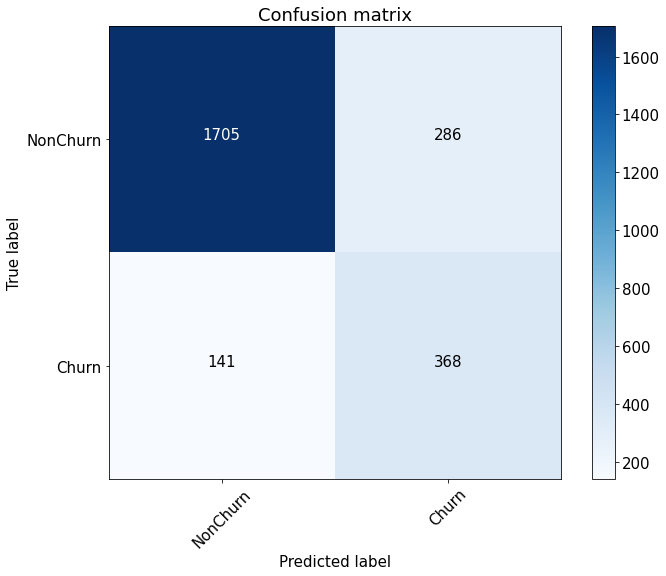

In [239]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Можно заметить, что мы очень сильно ошибаемся в сторону False Negatives, т.е у нас много тех, кто ушел в отток на самом деле, но при выбранном нами пороге в 0.38 мы не считаем их таковыми. 

<b>Вопрос 2: предположим, что на удержание одного пользователя у нас уйдет 1 доллар. При этом средняя ожидаемая прибыль с каждого TP (true positive) - 2 доллара. Оцените качество модели выше с учетом этих данных и ответьте на вопрос, является ли она потенциально экономически целесообразной?</b>

Ваш ответ здесь: 

### Пример с перебором параметров с помощью GridSearch

Сетка с параметрами

In [208]:
from sklearn.model_selection import GridSearchCV

params={'classifier__max_features':[0.3, 0.5, 0.7],
        'classifier__min_samples_leaf':[1, 2, 3],
        'classifier__max_depth':[None]
        }

Запускаем перебор

In [209]:
grid_RFC = GridSearchCV(pipeline_RFC,
                    param_grid=params,
                    cv=6,
                    refit=False)

search_RFC = grid_RFC.fit(X_train, y_train)
search_RFC.best_params_

{'classifier__max_depth': None,
 'classifier__max_features': 0.5,
 'classifier__min_samples_leaf': 3}

grid_CB = GridSearchCV(pipeline_CB,
                    param_grid=params,
                    cv=6,
                    refit=False)

search_CB = grid_CB.fit(X_train, y_train)
search_CB.best_params_

grid_LR = GridSearchCV(pipeline_LR,
                    param_grid=params,
                    cv=6,
                    refit=False)

search_LR = grid_LR.fit(X_train, y_train)
search_LR.best_params_

Обучаем модель уже сновыми параметрами

In [ ]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(max_depth=None, max_features=0.5, 
                                          min_samples_leaf=3, random_state=42)),
])
pipeline.fit(X_train, y_train)

In [ ]:
preds = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Метрики немного стали выше

### Домашнее задание

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

### Ссылки

1. http://hyperopt.github.io/hyperopt/
2. https://arxiv.org/pdf/1907.03947.pdf
3. https://arxiv.org/pdf/1802.02301.pdf
4. https://arxiv.org/list/stat.ML/recent
5. https://scikit-learn.org/stable/modules/grid_search.html
6. https://scikit-learn.org/stable/modules/compose.html
7. https://habr.com/ru/post/292312/
8. https://habr.com/ru/post/436236/
9. https://lifetimes.readthedocs.io/en/master/